In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, precision_recall_fscore_support
from sklearn.metrics import roc_curve, RocCurveDisplay
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Testing Undersampling

In [6]:
features = list(df.columns[:-1])

In [7]:
X = df[features]
y = df['Class']

It's necessary to perform some form of resampling (under-sampling / over-sampling) in order to deal with the imbalanced dataset, else the final model predictions will be heavily skewed. In original dataset there are 284315 observations of class 0 (not fraudulent) and 492 observations of class 1 (fraudulent).

In [8]:
# Undersampling method
undersample = NearMiss(version=1, n_neighbors=3)

In [9]:
# Avoid introducing any data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train_resample, y_train_resample = undersample.fit_resample(X_train, y_train)
#X_train_resample, y_train_resample = pipeline.fit_resample(X, y)

In [10]:
#scaler = StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

scaler = StandardScaler().fit(X_train_resample)
X_train_scaled = scaler.transform(X_train_resample)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Making sure decision variables are scaled
for i in range(X_train_scaled.shape[1]):
      print(f"{X_train_scaled[:,i].mean()}\t{X_train_scaled[:,i].std()}")

-5.410223876345941e-17	1.0
-7.21363183512792e-17	1.0
-7.21363183512792e-17	0.9999999999999999
3.60681591756396e-17	1.0
0.0	1.0
0.0	1.0
0.0	0.9999999999999999
0.0	1.0
-1.80340795878198e-17	1.0
0.0	0.9999999999999998
-3.60681591756396e-17	1.0
7.21363183512792e-17	1.0
-2.1640895505383763e-16	1.0
0.0	0.9999999999999998
-7.21363183512792e-17	1.0
-1.80340795878198e-17	0.9999999999999999
0.0	0.9999999999999999
-3.60681591756396e-17	1.0
0.0	0.9999999999999999
0.0	1.0
3.60681591756396e-17	1.0
9.0170397939099e-18	0.9999999999999998
1.3525559690864852e-17	0.9999999999999998
1.1271299742387375e-18	1.0
0.0	1.0
4.50851989695495e-18	1.0
1.3525559690864852e-17	0.9999999999999998
-9.0170397939099e-18	1.0
9.0170397939099e-18	1.0
5.410223876345941e-17	0.9999999999999999


In [12]:
# Note: Experiment with C param (inverse of regularization strength) and class_weight param (weights associated wwith classes)
logit = LogisticRegression(class_weight="balanced").fit(X_train_scaled, y_train_resample)
#logit = LogisticRegression(class_weight="balanced").fit(X_train_scaled, y_train)
#logit = LogisticRegression(class_weight={0:0.05, 1:0.95}).fit(X_train_scaled, y_train)

In [13]:
y_prob_pred = logit.predict_proba(X_test_scaled)[:,1]

Optimal threshold:  0.6579409241930062


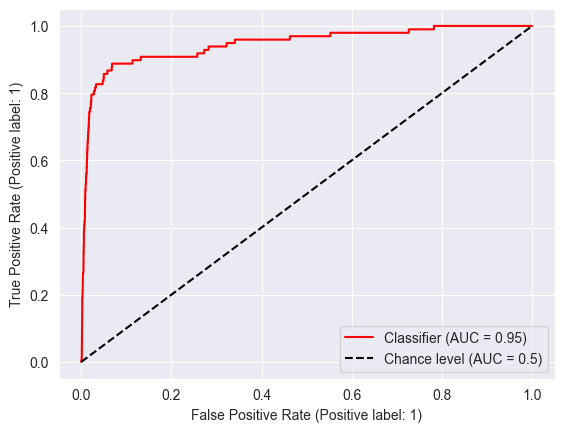

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_pred)
opt_idx = np.argmax(tpr-fpr)
opt_threshold = thresholds[opt_idx]
print("Optimal threshold: ", opt_threshold)
RocCurveDisplay.from_predictions(y_test, y_prob_pred, color="red", plot_chance_level=True)

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_pred)

Text(0.5, 1.0, 'Precision-Recall Curve')

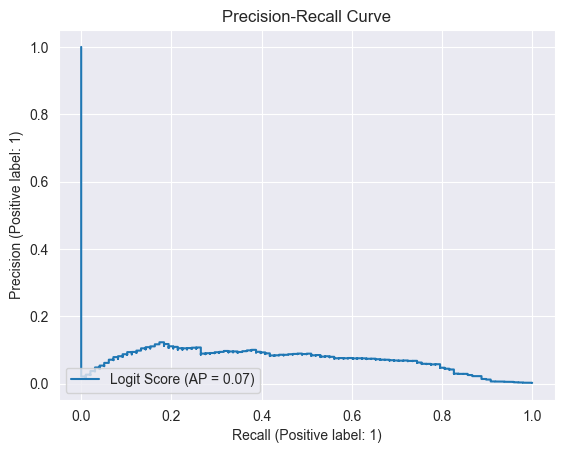

In [16]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob_pred, name="Logit Score")
display.ax_.set_title("Precision-Recall Curve")

In [17]:
y_pred = np.array([1 if p > opt_threshold else 0 for p in y_prob_pred])

In [18]:
y_pred.shape

(56962,)

In [21]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')

In [22]:
print(f"Precision: {precision} \n"
      f"Recall: {recall} \n"
      f"Fscore: {fscore} \n"
      f"Support: {support}")

Precision: 0.5107070989741617 
Recall: 0.9045886784651959 
Fscore: 0.5033686867281408 
Support: None


After evaluation, our precision is poor and recall is decent. This can indicate that our model is good at predicting the fraud class (i.e, good at identifying true positive) but becomes confused for the non-fraud class (i.e, more instances of false positives). We can try to reduce the undersampling rate, as well as attempt other resampling methods.

## Testing SMOTE oversampling

In [54]:
def evaluate(y_prob_pred):
      fpr, tpr, thresholds = roc_curve(y_test, y_prob_pred)
      opt_idx = np.argmax(tpr-fpr)
      opt_threshold = thresholds[opt_idx]
      print("Optimal threshold: ", opt_threshold)
      RocCurveDisplay.from_predictions(y_test, y_prob_pred, color="red", plot_chance_level=True)
      
      precision, recall, thresholds = precision_recall_curve(y_test, y_prob_pred)
      display = PrecisionRecallDisplay.from_predictions(y_test, y_prob_pred, name="Logit Score")
      display.ax_.set_title("Precision-Recall Curve")
      
      y_pred = np.array([1 if p > opt_threshold else 0 for p in y_prob_pred])
      precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
      print(f"Precision: {precision} \n"
            f"Recall: {recall} \n"
            f"Fscore: {fscore} \n"
            f"Support: {support}")
      
      return y_pred

In [55]:
# Oversampling method
# SMOTE paper recommends combining SMOTE minority sampling with random undersampling of majority class
oversample = SMOTE()
random_under = RandomUnderSampler()
steps = [('over', oversample), ('random', random_under)]
pipeline = Pipeline(steps=steps) 

I use either the liblinear or newton-cholesky solvers this time, because the lbfgs algorithm fails to converge.

In [56]:
X = df[features]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train_resample, y_train_resample = pipeline.fit_resample(X_train, y_train)
scaler = StandardScaler().fit(X_train_resample)
X_train_scaled = scaler.transform(X_train_resample)
X_test_scaled = scaler.transform(X_test)
logit = LogisticRegression(penalty='l2', class_weight="balanced", solver='newton-cholesky').fit(X_train_scaled, y_train_resample)
y_prob_pred = logit.predict_proba(X_test_scaled)[:,1]

Optimal threshold:  0.18336276126719278
Precision: 0.5237023896548756 
Recall: 0.9384126681060719 
Fscore: 0.5372018599488535 
Support: None


array([0, 0, 0, ..., 0, 0, 0])

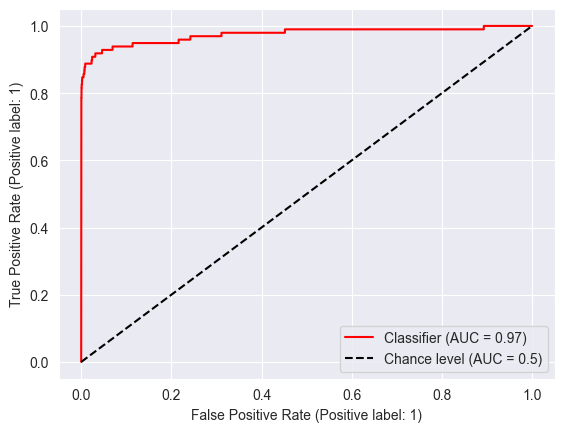

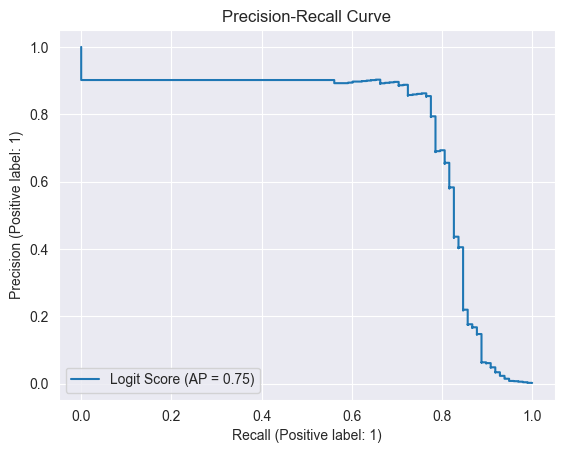

In [57]:
evaluate(y_prob_pred)

In [58]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedShuffleSplit

In [59]:
model = LogisticRegression(penalty='l2', class_weight="balanced", solver='newton-cholesky')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
scores = cross_val_score(model, X ,y, scoring='roc_auc', cv=cv, n_jobs=1)

In [60]:
scores.mean()

0.9799318801578811

In [61]:
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
steps = [(('smote', SMOTE())), ('random', RandomUnderSampler()), ('scale', StandardScaler()), ('clf', LogisticRegression(penalty='l2', class_weight='balanced', solver='newton-cholesky'))]
pipeline = Pipeline(steps=steps) 
pipeline.fit(X_train, y_train)
y_prob_pred = pipeline.predict_proba(X_test)[:,1]

Optimal threshold:  0.3672316793171916
Precision: 0.5547401354005236 
Recall: 0.9326380594443742 
Fscore: 0.5943652432517507 
Support: None


array([0, 0, 0, ..., 0, 0, 0])

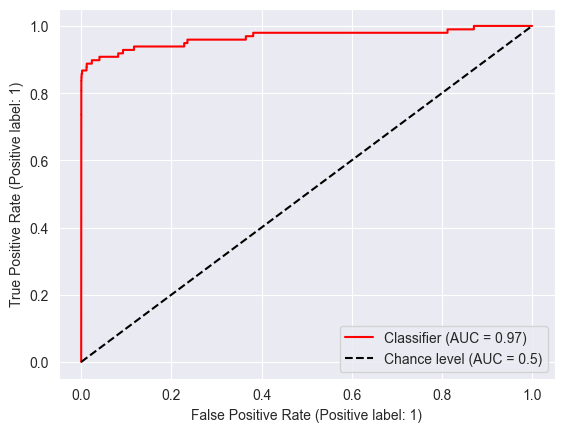

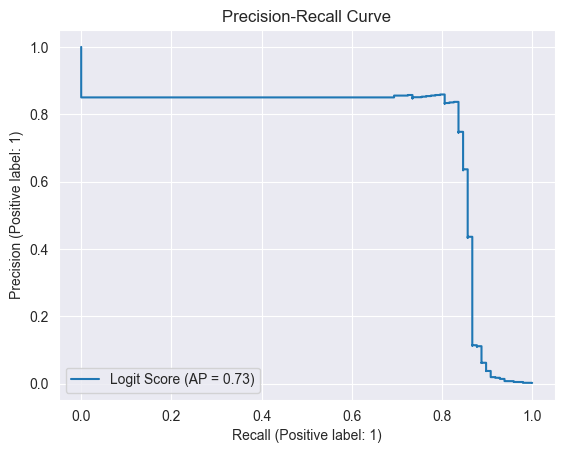

In [62]:
evaluate(y_prob_pred)

At least for logistic regression, SMOTE with random undersampling seems to have marginally better performance. I will now test with other models.

## Testing RandomForestClassifier

In [64]:
from sklearn.ensemble import RandomForestClassifier

Optimal threshold:  0.03
Precision: 0.5464849093071662 
Recall: 0.9264017333157235 
Fscore: 0.5804387708019965 
Support: None


array([0, 0, 0, ..., 0, 0, 0])

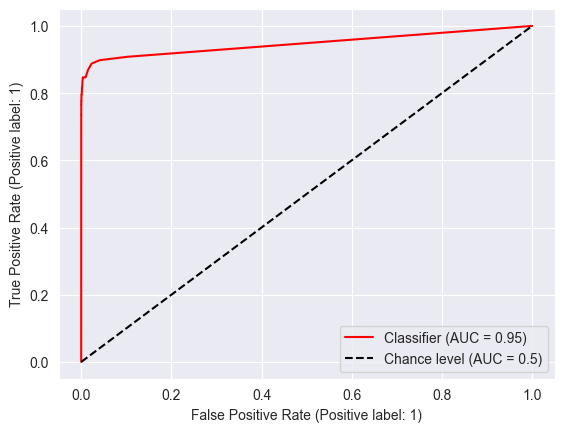

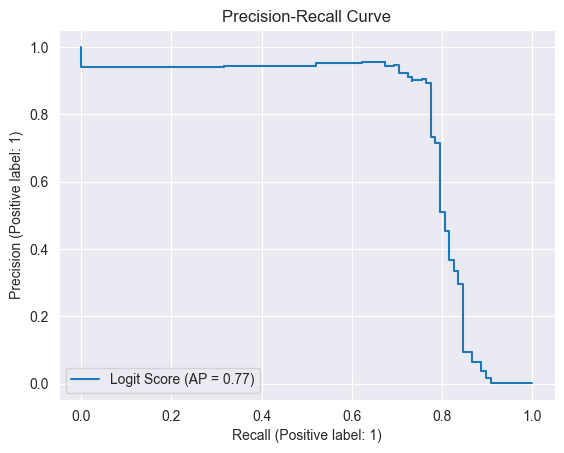

In [65]:
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
steps = [(('smote', SMOTE())), ('random', RandomUnderSampler()), ('scale', StandardScaler()), ('clf', RandomForestClassifier(class_weight='balanced'))]
pipeline = Pipeline(steps=steps) 
pipeline.fit(X_train, y_train)
y_prob_pred = pipeline.predict_proba(X_test)[:,1]
evaluate(y_prob_pred)


While Fscore is improving, the precision still leaves much to be desired. If switching to another model didn't yield as large an increase in performance, I will try PCA next.

## With PCA

In [67]:
from sklearn.decomposition import PCA

Optimal threshold:  0.6468030374957259
Precision: 0.5979760952470432 
Recall: 0.9204797985598292 
Fscore: 0.6577438067891077 
Support: None


array([0, 0, 0, ..., 0, 0, 0])

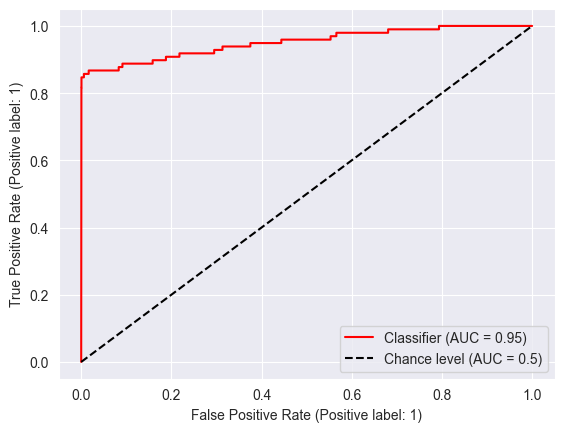

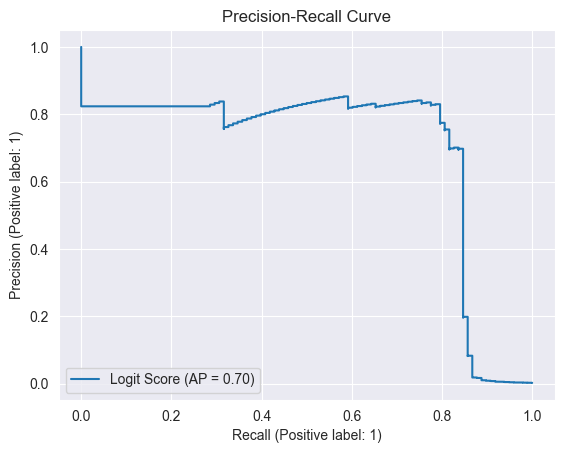

In [74]:
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
steps = [(('smote', SMOTE())), ('random', RandomUnderSampler()), ('scale', StandardScaler()), ('pca', PCA(n_components=7)), ('clf', LogisticRegression(penalty='l2', class_weight="balanced", solver='newton-cholesky'))]
pipeline = Pipeline(steps=steps) 
pipeline.fit(X_train, y_train)
y_prob_pred = pipeline.predict_proba(X_test)[:,1]
evaluate(y_prob_pred)

Optimal threshold:  0.32965855539864963
Precision: 0.5760310063391376 
Recall: 0.904250420624074 
Fscore: 0.626367684947451 
Support: None


array([0, 0, 0, ..., 0, 0, 0])

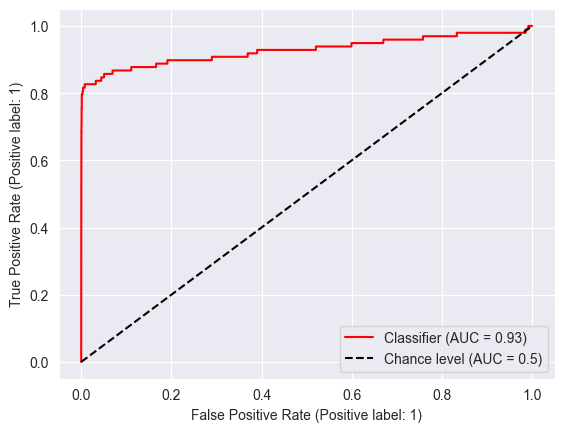

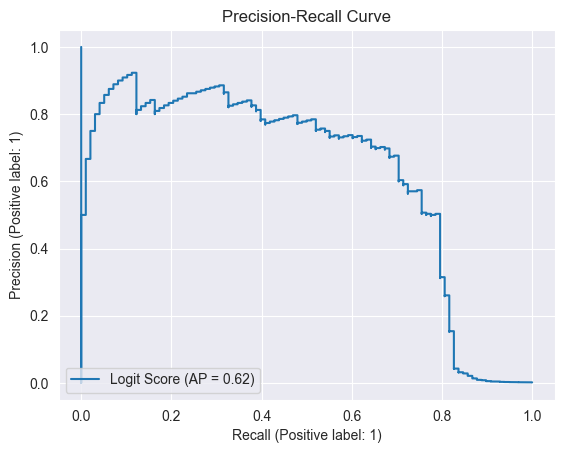

In [78]:
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
steps = [(('smote', SMOTE())), ('random', RandomUnderSampler()), ('scale', StandardScaler()), ('pca', PCA(n_components=7)), ('clf', RandomForestClassifier(n_estimators=20, max_depth=10, class_weight='balanced', max_features='sqrt'))]
pipeline = Pipeline(steps=steps) 
pipeline.fit(X_train, y_train)
y_prob_pred = pipeline.predict_proba(X_test)[:,1]
evaluate(y_prob_pred)

PCA yields a respectable improvement in precision score, and minimizing the amount of estimators and max_depth in the RandomForestClassifier also improves performance and training time.